In [1]:
%matplotlib inline
from detail import Detail
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import os,sys
import pylab
import json
import random
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
def shutup(func):
    def wrapper(*args, **kwargs):        
        save_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        res = func(*args, **kwargs)
        sys.stdout = save_stdout
        return res
    return wrapper

In [3]:
annFile='/Users/zhishuaizhang/pascal_in_detail_data/trainval_merged.json' # annotations
imgDir='/Users/zhishuaizhang/pascal_in_detail/VOCdevkit/VOC2010/JPEGImages' # jpeg images
phase='trainval'

In [4]:
# initialize detail api for instance annotations
details = Detail(annFile, imgDir, phase)

print('\n***info***')
details.info()

loading annotations into memory...
Done (t=12.19s)
creating index...
index created! 9.94s

***info***
description: This is the 3.0 version of the CVPR 2017 PASCAL in Detail dataset.
version: 3.0
year: 2017
contributor: https://sites.google.com/view/pasd
date_created: 2017-07-18


In [5]:
from detail import bboxEval
proposaleval = bboxEval.bboxEval(details)

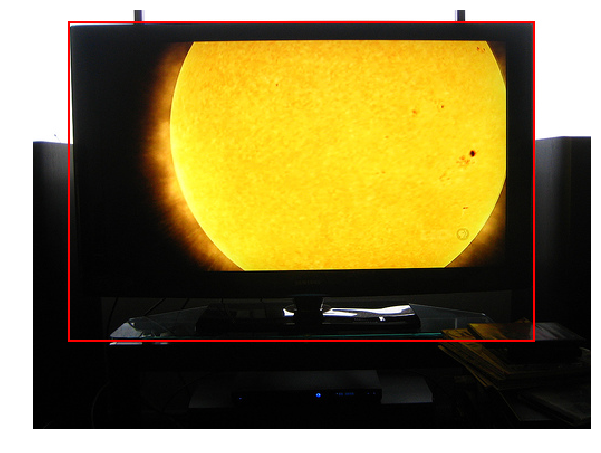

[{'bbox': [32, 10, 416, 286], 'category': 'tvmonitor'}]


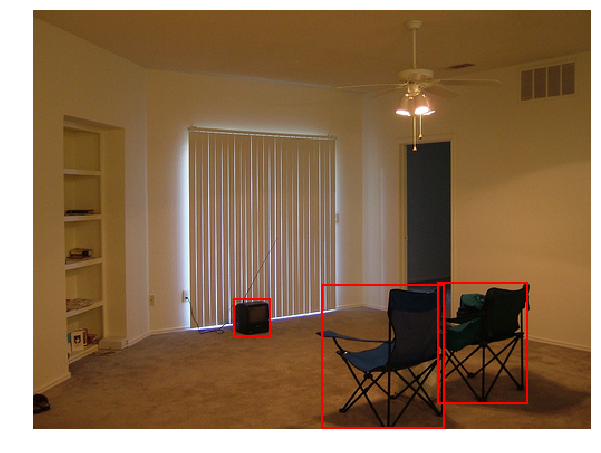

[{'bbox': [258, 246, 110, 128], 'category': 'chair'}, {'bbox': [362, 244, 80, 107], 'category': 'chair'}, {'bbox': [179, 258, 33, 33], 'category': 'tvmonitor'}]


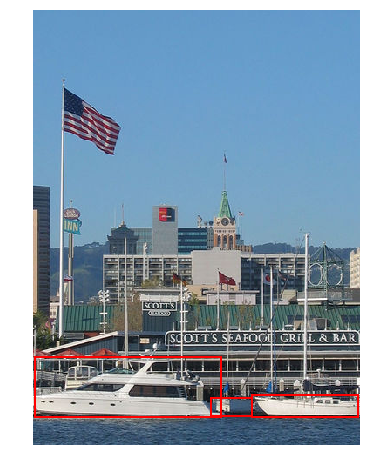

[{'bbox': [2, 399, 213, 69], 'category': 'boat'}, {'bbox': [251, 442, 122, 25], 'category': 'boat'}, {'bbox': [204, 446, 47, 20], 'category': 'boat'}]


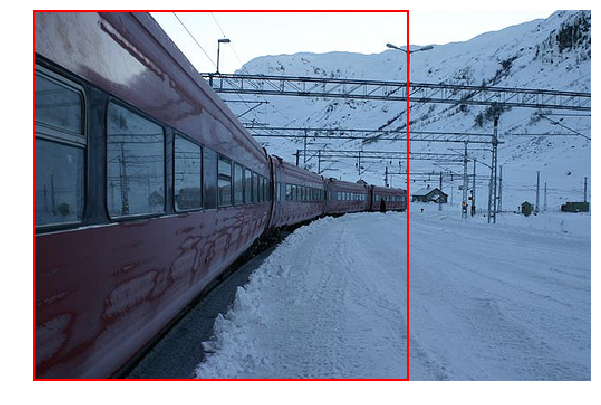

[{'bbox': [0, 0, 335, 331], 'category': 'train'}]


In [6]:
# Simplify the image and category list to make debug / test easier
proposaleval.params.imgIds = [2008000002,2008000070,2008000140,2008000470]
proposaleval.params.catIds = [31,72,416,427]
proposaleval.params.useCat = False
proposaleval.params.maxDets = [1, 10, 100, 1000, np.inf]

# 31 : boat
# 72 : chair
# 416 : train
# 427 : tvmonitor

# Let's check the ground truth
for _ in proposaleval.params.imgIds:
    print(shutup(details.getBboxes)(_, show=True))


In [7]:
proposaleval.loadBoxRes(resFile=\
                    '../res/objectness_correct.json')
proposaleval.evaluate()
proposaleval.accumulate()

In [8]:
print(proposaleval.recall[9,-1]) # Recall@K=inf,IOU=0.95
print(proposaleval.recall[0,-1]) # Recall@K=inf,IOU=0.5
print(proposaleval.recall[9,0]) # Recall@K=1,IOU=0.95
print(proposaleval.recall[0,0]) # Recall@K=1,IOU=0.5
# This is the perfect proposal, so IOU=0.5 or 0.95 doesn't matter
# There are 8 objects in total, in 4 images. If you only allow K=1
# Then only 4 objects will be detected, so the recall will be only 4/8 = 0.5
# Work as expected

1.0
1.0
0.5
0.5


In [9]:
proposaleval.loadBoxRes(resFile=\
                    '../res/objectness_correct_but_only_half_matched.json')
proposaleval.evaluate()
proposaleval.accumulate()

In [10]:
print(proposaleval.recall[9,-1]) # Recall@K=inf,IOU=0.95
print(proposaleval.recall[0,-1]) # Recall@K=inf,IOU=0.5
print(proposaleval.recall[9,0]) # Recall@K=1,IOU=0.95
print(proposaleval.recall[0,0]) # Recall@K=1,IOU=0.5
# This time the boxes are not perfect, so when we ask IOU to be 0.95
# The recall will be lower
# Work as expected

0.75
1.0
0.25
0.5


In [11]:
# Create a detection result from groundtruth of 1001 images
# This cell will take 2 mins in my computer
proposaleval = bboxEval.bboxEval(details)
all_gt = []
imgIds_ = []
for i in proposaleval.params.imgIds:
    if len(imgIds_) > 1000:
        break
    imgIds_.append(i)
    bbox=shutup(details.getBboxes)(i, show=False)
    for _ in bbox:
        all_gt.append(dict())
        all_gt[-1]['image_id'] = i
        all_gt[-1]['bbox'] = _['bbox']
        all_gt[-1]['score'] = 100.

In [12]:
with open('../res/objectness_huge_gt.json', 'w') as outfile:
    json.dump(all_gt, outfile)

In [13]:
# Test with a larger detection result, consisting of 1001 images
# This cell will take 2 mins in my computer
proposaleval = bboxEval.bboxEval(details)
proposaleval.params.imgIds = proposaleval.params.imgIds[:1001]
proposaleval.params.useCat = False
proposaleval.params.maxDets = [1, 10, 100, 1000, np.inf]
proposaleval.loadBoxRes(resFile=\
                    '../res/objectness_huge_gt.json')
proposaleval.evaluate()
proposaleval.accumulate()

In [14]:
print(proposaleval.recall[9,-1]) # Recall@K=inf,IOU=0.95
print(proposaleval.recall[0,-1]) # Recall@K=inf,IOU=0.5
print(proposaleval.recall[9,0]) # Recall@K=1,IOU=0.95
print(proposaleval.recall[0,0]) # Recall@K=1,IOU=0.5
# Work as expected ? Why they are 0.997 instead of 1 ? -- To be checked

0.99701715138
0.997390007457
0.373228933632
0.373228933632
